# 🐦 Notebook 01 — Exploratory Bird Detection

**Goal:**  
This notebook explores the practical challenges of bird detection in real-world imagery.  
Instead of chasing a “perfect” model, the objective is to *experiment*, *observe failure modes*, and *document insights* — like a researcher would.

This aligns with the real-world ecological ML constraints described in the Salvin’s albatross paper I read.

---

### 🔍 What I’m Doing Here

- Try a **general wildlife detector** (MegaDetector) on a few images  
- Try a **bird species detector** (weecology/everglades-bird-species-detector) even though it isn’t drone-specific  
- Compare outputs  
- Record what works, what doesn’t, and why  
- Think critically about **domain shift**, **tiny-object detection**, and **model suitability**  

This notebook is intentionally exploratory.

### 1. Setup

In [1]:
# Minimal setup
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Optional: make plots bigger
plt.rcParams["figure.figsize"] = (8, 6)

In [2]:
# Environment check (NumPy/Torch)
import numpy as np, sys
try:
    import torch
    print(f"numpy: {np.__version__}")
    print(f"torch: {torch.__version__}")
except Exception as e:
    print("Environment issue while importing torch. If you see NumPy-related errors, try:")
    print("  pip install 'numpy<2.0'  # or reinstall packages built against NumPy 2.x")
    print("Original error:", repr(e))

numpy: 1.26.4
torch: 2.2.2


### 2. Load the Model

In [3]:
# Load YOLO-based general detector (COCO-pretrained)
model = YOLO("yolov8x.pt")
names = model.names  # dict: id -> class name
bird_class_ids = [k for k, v in names.items() if v == "bird"]
print(f"Model loaded. Bird class ids: {bird_class_ids}")

Model loaded. Bird class ids: [14]


In [5]:
# Helpers
from typing import List, Tuple

def load_images(paths: List[Path]) -> List[np.ndarray]:
    imgs = []
    for p in paths:
        if not p.exists():
            print(f"Warning: missing file {p}")
            imgs.append(None)
            continue
        img = cv2.imread(str(p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return imgs


def draw_detections(img: np.ndarray, boxes: List[Tuple[int,int,int,int]], labels: List[str], scores: List[float]):
    vis = img.copy()
    for (x1, y1, x2, y2), cls, conf in zip(boxes, labels, scores):
        color = (0, 255, 0)
        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)
        cv2.putText(vis, f"{cls} {conf:.2f}", (x1, max(0, y1 - 6)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    return vis

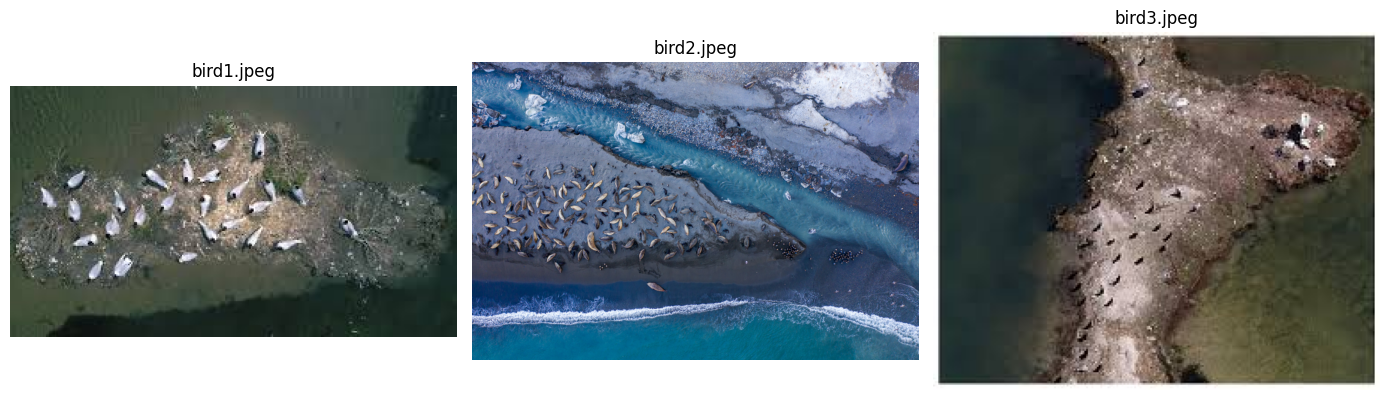

In [4]:
# Define image paths and load
base = Path("../data/sample_images")
img_paths = [base / "bird1.jpeg", base / "bird2.jpeg", base / "bird3.jpeg"]
imgs = load_images(img_paths)

# Preview
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for i, (ax, im, p) in enumerate(zip(axs, imgs, img_paths)):
    if im is None:
        ax.set_title(f"Missing: {p.name}")
        ax.axis("off")
        continue
    ax.imshow(im)
    ax.set_title(p.name)
    ax.axis("off")
plt.tight_layout()

In [7]:
# Predict on all three images and filter to birds
preds = []
conf_thr = 0.25
for im in imgs:
    if im is None:
        preds.append(None)
        continue
    res = model.predict(im, conf=conf_thr, verbose=False)
    res0 = res[0]
    if res0.boxes is not None:
        boxes_xyxy = res0.boxes.xyxy.cpu().numpy().astype(int)
        cls_ids = res0.boxes.cls.cpu().numpy().astype(int)
        scores = res0.boxes.conf.cpu().numpy()
    else:
        boxes_xyxy = np.empty((0, 4), dtype=int)
        cls_ids = np.array([], dtype=int)
        scores = np.array([], dtype=float)
    if len(bird_class_ids) > 0:
        keep = np.isin(cls_ids, bird_class_ids)
    else:
        keep = np.ones_like(cls_ids, dtype=bool)
    boxes = boxes_xyxy[keep]
    labels = [names[c] for c in cls_ids[keep]] if cls_ids.size else []
    scores_f = scores[keep]
    preds.append(dict(boxes=boxes, labels=labels, scores=scores_f))
print("Predictions complete.")

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Predictions complete.


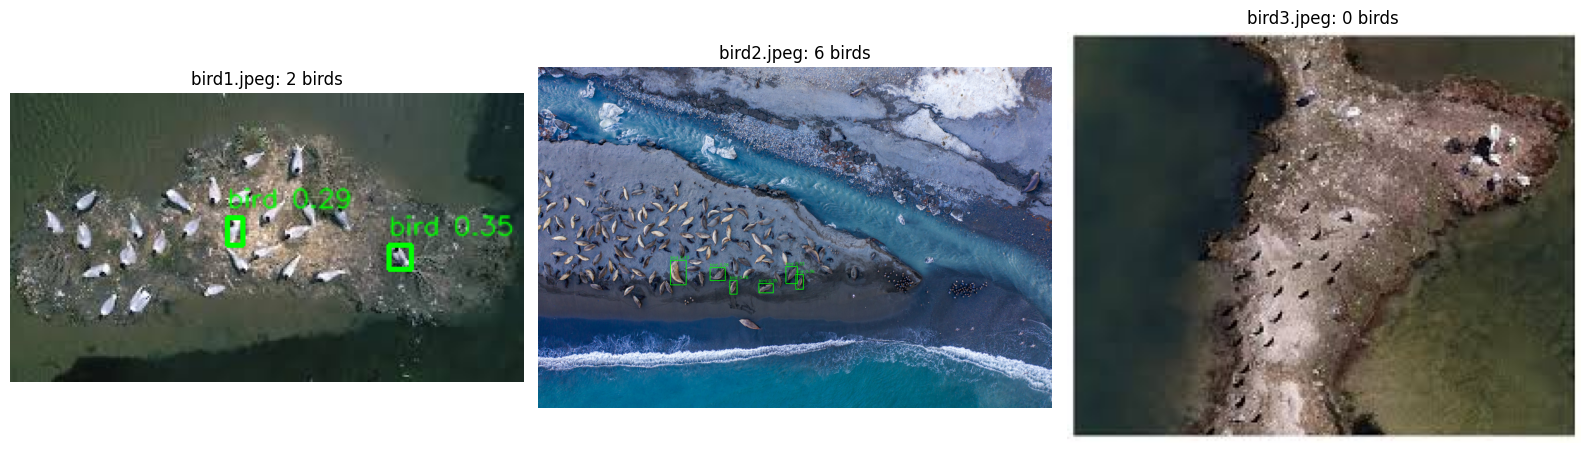

In [10]:
# Visualize detections for each image
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for ax, im, pr, p in zip(axs, imgs, preds, img_paths):
    ax.axis("off")
    if im is None or pr is None:
        ax.set_title(f"Missing: {p.name}")
        continue
    boxes = pr["boxes"]
    labels = pr["labels"]
    scores = pr["scores"]
    vis = draw_detections(im, boxes, labels, scores)
    ax.imshow(vis)
    ax.set_title(f"{p.name}: {len(boxes)} birds")
plt.tight_layout()

In [11]:
# Basic evaluation summary
from statistics import mean

summary = []
for im, pr, p in zip(imgs, preds, img_paths):
    if im is None or pr is None:
        summary.append(dict(image=p.name, birds=0, mean_conf=None, mean_rel_area=None))
        continue
    h, w = im.shape[:2]
    areas = []
    for (x1, y1, x2, y2) in pr["boxes"]:
        areas.append(((x2 - x1) * (y2 - y1)) / float(w * h + 1e-9))
    birds = len(pr["boxes"]) if pr["boxes"] is not None else 0
    mean_conf = float(mean(pr["scores"])) if birds > 0 else None
    mean_rel_area = float(mean(areas)) if birds > 0 else None
    summary.append(dict(image=p.name, birds=birds, mean_conf=mean_conf, mean_rel_area=mean_rel_area))

for row in summary:
    print(row)

# Quick heuristic: tiny-object difficulty if mean_rel_area < ~0.002
for row in summary:
    if row["mean_rel_area"] is not None and row["mean_rel_area"] < 0.002:
        print(f"Note: {row['image']} likely contains tiny birds (<0.2% of image area), challenging for generic YOLO.")

{'image': 'bird1.jpeg', 'birds': 2, 'mean_conf': 0.31951266527175903, 'mean_rel_area': 0.0032449434623347023}
{'image': 'bird2.jpeg', 'birds': 6, 'mean_conf': 0.33439525961875916, 'mean_rel_area': 0.0010626876876876873}
{'image': 'bird3.jpeg', 'birds': 0, 'mean_conf': None, 'mean_rel_area': None}
Note: bird2.jpeg likely contains tiny birds (<0.2% of image area), challenging for generic YOLO.


### 6. Evaluate (Basic)

If dataset has boxes or points.

### 7. Notes + Observations

You will write:
- How well zero-shot works
- What birds it misses
- Where false positives happen
- Habitat patterns
